# Fairness and proxy variables: Identifying and Mitigating Information Leakage for Fair Data Science
by Gilad Aharoni and Yonatan Lahat

In this project, we explore fairness considerations in machine learning models. Our goal is to assess and mitigate bias related to sensitive attributes (such as gender or race) while maintaining model effectiveness.

In this notebook, we will use the [Students Performance dataset](https://https://archive.ics.uci.edu/dataset/320/student+performance) to investigate fairness and potential bias related to students' final grades based on their gender. This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).

## installation and settings

In [64]:
! pip install ucimlrepo

In [65]:
import itertools
import numpy as np
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from ucimlrepo import fetch_ucirepo
from hyperopt import hp, fmin, tpe, Trials, space_eval
import lightgbm as lgb
import sklearn as sk
from sklearn import metrics
import matplotlib.pyplot as plt

## Data preprocessing

As an integral part of our data pipeline, we have created a `DataSet` class. This class encapsulates the original column names, identifies the protected and target features, and encompasses the preprocessed data. By organizing the data within this class, we ensure consistency and facilitate subsequent analysis.




In [66]:
class DataSet:
    def __init__(self):
        self.columns = []
        self.target = 0
        self.protected = 0
        self.data = pd.DataFrame()

This two methods are used to preprocess the data, `preprocess_data` uses one hot encoding to process categorical features and `binarization` convert contious feature to binaric one by splitting in the median.

In [67]:
def preprocess_data(data):
    for column in data.columns:
        # binary encoding
        if len(data[column].unique()) == 2:
            data[column] = data[column].map(lambda x: x == data[column].unique()[0]).astype(int)
        # one hot encoding for categorical variables
        elif data[column].dtype == 'object':
            one_hot_encoded = pd.get_dummies(data[column], prefix=column)
            data = pd.concat([data.drop(column, axis=1), one_hot_encoded], axis=1)
    return data

In [68]:
def binarization(column):
    return column.map(lambda x: x > column.median()).astype(int)

The `StudentsDS` class extends the `DataSet` class for preprocessing the students performance dataset. The protected feature is `sex` where the privieged attribute is `F` (female). The target feature is the final grade, converted to a binaric feature.

In [69]:
class StudentsDS(DataSet):
    def __init__(self):
        super().__init__()
        student_performance = fetch_ucirepo(id=320)
        self.data = student_performance.data.features
        self.protected = self.data['sex'].map(lambda x: x != 'F').astype(int)
        self.data = self.data.drop(labels=['sex'], axis=1)
        self.target = binarization(student_performance.data.targets['G3'])
        self.columns = self.data.columns
        self.data = preprocess_data(self.data)

In [70]:
dataset = StudentsDS()

## Model and Prediction Settings

Every prediction in our project has the same process:
- Data Preparation:
1. Define data points X (features) and a binary target feature y (e.g., pass/fail, yes/no).
2. Split the dataset into training and test sets.
- Model Training:
3.  Utilize the training set to train a LightGBM model—a gradient boosting-based algorithm.
4.  LightGBM is known for its efficiency and accuracy in handling large datasets.
- Hyperparameter Tuning:
5. Fine-tune the model's hyperparameters using the hyperopt module.
6. Employ k-fold cross-validation on the training split to assess parameter reliability.
- Model Evaluation:
7. Evaluate the trained model's performance using the AUROC (Area Under the Receiver Operating Characteristic) score.
8. AUROC measures the model's ability to distinguish between positive and negative instances.


### hyperparameter tunning

In [71]:
def check_parameters(params):
    params['num_leaves'] = max(int(params['num_leaves']), 2)
    params['max_depth'] = max(int(params['max_depth']), 2)
    params['n_estimators'] = max(int(params['n_estimators']), 1)
    return params

In [72]:
param_space = {
        'num_leaves': hp.randint('num_leaves', 130) + 20,
        'max_depth': hp.quniform('max_depth', 2, 10, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
        'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

The main `prediction` function. It also used to describe the relation between a group of features to a single feature, describing it as a binaric classification problem.

In [73]:
def prediction(X, y):
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3)

    def objective(params):
        params = check_parameters(params)
        model = lgb.LGBMClassifier(**params, verbose=-1)
        kf = sk.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        auroc_scores = []
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict_proba(X_val_fold)
            for i in range(len(model.classes_)):
                class_label = model.classes_[i]
                y_pred_proba_class = y_pred[:, i]
                auroc_score = sk.metrics.roc_auc_score((y_val_fold == class_label).astype(int), y_pred_proba_class)
                auroc_scores.append(auroc_score)
        return -np.mean(auroc_scores)

    trials = Trials()
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=20, trials=trials)
    best_params = check_parameters(best_params)
    best_model = lgb.LGBMClassifier(**best_params, verbose=-1)
    best_model.fit(X_train, y_train)

    predicts = best_model.predict_proba(X_test)
    auroc_scores = []
    for i in range(len(best_model.classes_)):
        class_label = best_model.classes_[i]
        y_pred_proba_class = predicts[:, i]
        auroc_score = sk.metrics.roc_auc_score((y_test == class_label).astype(int), y_pred_proba_class)
        auroc_scores.append(auroc_score)
    return best_model, np.mean(auroc_scores)

In [74]:
def plot_roc_curve(X ,y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)

    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='b', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

100%|██████████| 20/20 [00:03<00:00,  6.50trial/s, best loss: -0.8087521440789096]


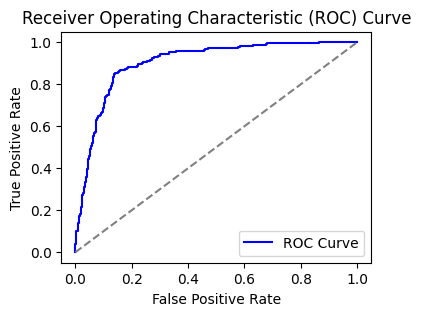

The initial AUROC score:0.7170826161790018


In [75]:
model, score = prediction(dataset.data, dataset.target)
plot_roc_curve(dataset.data, dataset.target, model)
print(f"The initial AUROC score:{score}")

## Bias and Fairness Evaluation


Our main metric for fairness evaluation is the DIR - disparate impact ratio, which is defined:

DIR = P(R=1|unprivileged)/ P(R=1|privileged)

In [76]:
def one_columns_eval(y_pred, protected):
    numerator = ((y_pred == 1) & (protected == 1)).sum() / (protected == 1).sum()
    denominator = ((y_pred == 1) & (protected == 0)).sum() / (protected == 0).sum()
    return numerator / denominator

In [77]:
def evaluate_fairness(model, dataset: DataSet):
    y_pred = model.predict(dataset.data)
    return one_columns_eval(y_pred, dataset.protected)

In [78]:
init_fairness = evaluate_fairness(model, dataset)
print(f"The inital fairness is {init_fairness}")

The inital fairness is 0.8193619407635111


## Bias Mitigating using sequential feature selection
Now we can use the first approach for mitigating proxy features.

In [79]:
def select_best_features(estimator, X, y, n_features=3):
    sfs = SequentialFeatureSelector(estimator, n_features_to_select=n_features)
    sfs.fit(X, y)
    selected_features = X.columns[sfs.get_support()]
    return selected_features

The selected proxy features are:  age, Walc, Mjob_teacher
100%|██████████| 20/20 [00:08<00:00,  2.45trial/s, best loss: -0.7922408801542952]


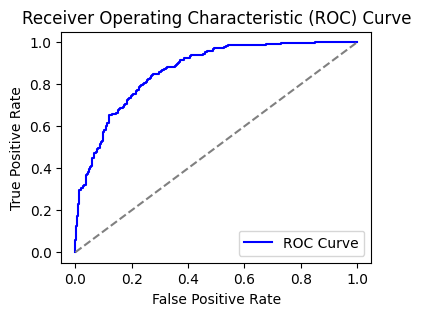

the last fairness balance is 0.9833119383825417, the fixed auroc is now 0.7643491444661035
the fairness was increased by 20.009471939379573%


In [80]:
proxy_features = select_best_features(model,dataset.data,dataset.protected)
print("The selected proxy features are: ", ", ".join(list(proxy_features)))
reduced_dataset = StudentsDS()
reduced_dataset.data = reduced_dataset.data.drop(list(proxy_features), axis=1)
fair_model, fair_score = prediction(reduced_dataset.data, reduced_dataset.target)
fixed_fair = evaluate_fairness(fair_model, reduced_dataset)
plot_roc_curve(reduced_dataset.data, reduced_dataset.target, fair_model)
print(f"the last fairness balance is {fixed_fair}, the fixed auroc is now {fair_score}")
print(f"the fairness was increased by {((fixed_fair - init_fairness) / init_fairness) * 100}%")

We can also use the other approach, which used brute force prediction for every threesome of features.
The `brute_force_filtering` function explores all possible combinations of three columns from a given dataset. For each combination, it selects the corresponding columns, calculates a score (prediction performance), and stores the score along with the combination. Finally, it returns the columns associated with the best-performing combination (highest score). The goal is to find an optimal set of columns that can serve as a proxy for a protected attribute.






In [81]:
def brute_force_filtering(self):
        graded_combos = []
        combinations = list(itertools.combinations(self.columns, 3))
        for combo in combinations:
            selected_columns = [col for col in self.data.columns if any(col.startswith(prefix + "_") or prefix == col
                                                                        for prefix in combo)]
            potential_proxy = self.data[selected_columns].copy()
            _, score = prediction(potential_proxy, self.protected)
            graded_combos.append((score, combo))
        best_combo = max(graded_combos, key=lambda x: x[0])
        return [col for col in self.data.columns if any(col.startswith(prefix + "_") or prefix == col
                                                        for prefix in best_combo[1])]
DataSet.brute_force_filtering = brute_force_filtering

Since the brute force takes a long time (45 minutes), this function was ran in advance.

The selected proxy features are:  age, famsup, Dalc
100%|██████████| 20/20 [00:02<00:00,  8.29trial/s, best loss: -0.7719659838513534]


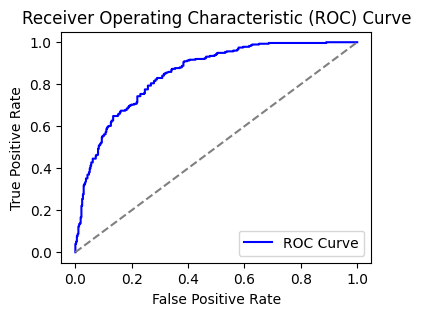

the last fairness balance is 0.8983677141571877, the fixed auroc is now 0.7560961582700713
the fairness was increased by 9.642353331673693%


In [83]:

# proxy_features = dataset.brute_force_filtering()
proxy_features = ('age', 'famsup', 'Dalc')
print("The selected proxy features are: ", ", ".join(list(proxy_features)))
reduced_dataset = StudentsDS()
reduced_dataset.data = reduced_dataset.data.drop(list(proxy_features), axis=1)
fair_model, fair_score = prediction(reduced_dataset.data, reduced_dataset.target)
fixed_fair = evaluate_fairness(fair_model, reduced_dataset)
plot_roc_curve(reduced_dataset.data, reduced_dataset.target, fair_model)
print(f"the last fairness balance is {fixed_fair}, the fixed auroc is now {fair_score}")
print(f"the fairness was increased by {((fixed_fair - init_fairness) / init_fairness) * 100}%")